In [1]:
! pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=dcfe229c0d2e3a7f9676af119ac8f5d5e689415b8b71cbd0b8c748c49e5d96fd
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("firstapp").getOrCreate()

In [27]:
df = spark.read.csv("/content/week_1_output.csv", header = True,inferSchema = True) #header = True,
#inferSchema = True - means tht all values will be given thier correct schema, otherwise it will give all as string 

In [28]:
df.show(5)

+----------+---------------+-----------------+------------------+--------+-------------+---------------+----------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+------------------+
|start_time|start time hour|start time minute|start time seconds|end_time|end_time hour|end_time minute|end_time seconds|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|     pyment|haversine_distance|
+----------+---------------+-----------------+------------------+--------+-------------+---------------+----------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+-

In [29]:
df.columns

['start_time',
 'start time hour',
 'start time minute',
 'start time seconds',
 'end_time',
 'end_time hour',
 'end_time minute',
 'end_time seconds',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender',
 'pyment',
 'haversine_distance']

In [8]:
#df.count() #returns number of rows in data 

In [9]:
#df.select(['bike_id', 'user_type']).show(3) #you select just the columns you want to see
#df.describe().show()

**From week2.task1**: task1-calculate the duration in seconds of each trip ( I formed a new column as trip, by substracting endtime and start time), however, we can also get same answer by also assuming that every row is a trip 

In [30]:
df1 = df.withColumn('start_time(s)', df[1]*3600 + df[2]*60 + df[3])
df2 = df1.withColumn('end_time(s)', df[5]*3600 + df[6]*60 + df[7])

#df2.show(['start_time(s)','end_time(s)'])

In [31]:
df3 = df2.withColumn('trip(s)', (df2['end_time(s)'] - df2['start_time(s)']))
#display('trip(s)')

### **Week3:task1:** calculate the number of trips for each start station list top 10 and find the ratio of using as male or female 

In [32]:
df.groupby('member_gender').count().show()

+-------------+------+
|member_gender| count|
+-------------+------+
|       Female| 95871|
|        Other|  6167|
|         Male|336593|
|         null| 63106|
+-------------+------+



In [33]:
import pyspark.sql.functions as F
#df = df.withColumn('test_column_1', F.when(F.col('member_gender' == 'Female') , 0).otherwise(1))
df11 = df3.withColumn('F', F.when(F.col('member_gender') == 'Female', 1).otherwise(0)).withColumn('M', F.when(F.col('member_gender') == 'Male', 1).otherwise(0))

df11.select('F', 'M','member_gender').show(10)

+---+---+-------------+
|  F|  M|member_gender|
+---+---+-------------+
|  0|  1|         Male|
|  1|  0|       Female|
|  0|  0|         null|
|  0|  0|         null|
|  1|  0|       Female|
|  0|  0|         null|
|  1|  0|       Female|
|  0|  0|         null|
|  0|  0|         null|
|  0|  0|         null|
+---+---+-------------+
only showing top 10 rows



In [34]:
#df_new = df3.groupby('start_station_name').count(df.trip(s)).show()

#Using agg count
from pyspark.sql.functions import desc

df4 = df11.groupBy('start_station_id').agg({'trip(s)':'count', 'F':'sum', 'M': 'sum'}).orderBy(desc('count(trip(s))')).head(10)

In [41]:
#df_new = df3.groupby('start_station_name').count(df.trip(s)).show()

#Using agg count
from pyspark.sql.functions import desc
df4 = df11.groupBy('start_station_id').agg({'trip(s)':'count', 'F':'sum', 'M': 'sum'}).orderBy(desc('count(trip(s))')).limit(10)

In [45]:
df5 = df4.withColumn('F_ratio', df4[1]/df4[3])
#df5.show()
df6 = df5.withColumn('M_ratio', df4[2]/df4[3])
df6.show(10)

+----------------+------+------+--------------+-------------------+------------------+
|start_station_id|sum(F)|sum(M)|count(trip(s))|            F_ratio|           M_ratio|
+----------------+------+------+--------------+-------------------+------------------+
|              15|  2594|  7911|         13899|0.18663213180804375|0.5691776386790417|
|               6|  1820|  6960|         12618|0.14423838960215565|0.5515929624346172|
|              30|  1878|  9116|         11654|0.16114638750643556|0.7822206967564784|
|              67|  1987|  8877|         11386| 0.1745125592833304|0.7796416652028807|
|              58|  1777|  8581|         11370|0.15628847845206684|0.7547053649956025|
|              21|  1552|  7876|         10650|0.14572769953051642|0.7395305164319249|
|              81|  2181|  7351|         10361|0.21050091689991313|0.7094875012064472|
|               3|  1702|  5796|          9649| 0.1763913358897295|0.6006840087055654|
|              22|  1872|  7003|          9

In [46]:
df4 = df3.groupBy('start_station_id').count().orderBy(desc('count')).show(10)

+----------------+-----+
|start_station_id|count|
+----------------+-----+
|              15|13899|
|               6|12618|
|              30|11654|
|              67|11386|
|              58|11370|
|              21|10650|
|              81|10361|
|               3| 9649|
|              22| 9269|
|              16| 9136|
+----------------+-----+
only showing top 10 rows



task2: make a comparison to find the percentage of usage for customer and subscriber

In [47]:
df1 = df.groupby('user_type').count().limit(2)
df1.show()


+----------+------+
| user_type| count|
+----------+------+
|Subscriber|396156|
|  Customer|105581|
+----------+------+



In [48]:
nb_subs = df1.take(1)[0][1]
cust =  df1.take(2)[1][1] 
percentage_subs = nb_subs*100/(nb_subs+cust)
percentage_subs
#specific_value = df.take(3)[2][4]
#This will retrieve the first 3 rows of the DataFrame df and select the 3rd row (at index 2 in the list of rows), and then select the 5th column (at index 4 in the list of columns). Note that indexing in PySpark is 0-based, so the 3rd row has an index of 2.

78.95690371648892

In [49]:
percentage_cust = cust*100/(nb_subs+cust)
percentage_cust

21.043096283511083

week3,task3: calculate the age of all users and show the relation between the distance and the age

In [52]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from datetime import datetime

df12 = df.withColumn("age", F.floor(F.datediff(F.current_timestamp(), F.col("member_birth_year"))/365.25))
df12_new = df12.na.drop(how= "any", subset = ["age"])
df12_new.select("age","member_birth_year",).show(5)

+---+-----------------+
|age|member_birth_year|
+---+-----------------+
| 36|             1987|
| 58|             1965|
| 26|             1997|
| 32|             1991|
| 33|             1990|
+---+-----------------+
only showing top 5 rows



In [53]:
df12_new = df12.groupby("age").agg({"haversine_distance": "mean"})
df12_new.show(3)

+---+-----------------------+
|age|avg(haversine_distance)|
+---+-----------------------+
| 26|     1.3314663758443506|
| 29|     1.5997178792192974|
| 65|     1.5495662635180862|
+---+-----------------------+
only showing top 3 rows



In [54]:
# convert to pandas and plot
pdf = df12_new.toPandas()

In [55]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

Text(0, 0.5, 'haversine_distance')

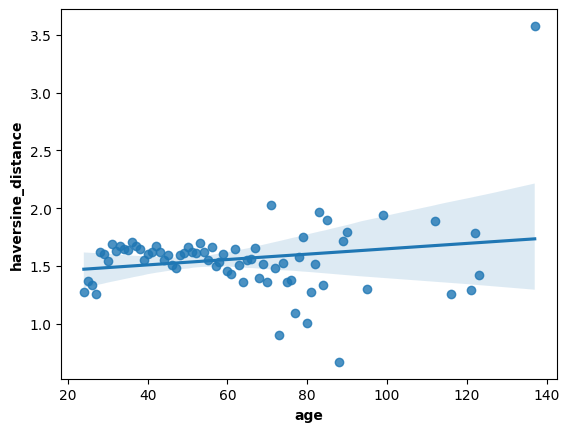

In [56]:
sn.regplot(x= "age", y= "avg(haversine_distance)", data=pdf)
plt.xlabel('age', weight = 'bold')
plt.ylabel('haversine_distance', weight = 'bold')